In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image

In [8]:
image_path = "Datasets/PadChest-GR/PadChest_GR/115263314615937124996392879313495388_od1tee.png"
np_image = np.array(Image.open(image_path))
print(np_image.shape)  # Should print (height, width, 3)

(2830, 2835)


In [2]:
images_path = "Datasets\MIMIC\matched_images_and_masks_mimic_224\images"
mask_path = "Datasets\MIMIC\matched_images_and_masks_mimic_224\masks"
image_type = ".jpg"

def plot_one_image(image_id):
    full_path = f"{images_path}/{image_id}{image_type}"
    if os.path.exists(full_path):
        with Image.open(full_path) as im:
                im = im.convert("RGB")
                return im

def plot_one_mask(mask_id):
    full_path = f"{mask_path}/{mask_id}{image_type}"
    if os.path.exists(full_path):
        with Image.open(full_path) as im:
                im = im.convert("RGB")
                return im
    return None

In [3]:
# LOAD first image found on images path
first_image_id = os.listdir(images_path)[0].split(".")[0]
first_mask_id = os.listdir(mask_path)[0].split(".")[0]
print(f"First image ID: {first_image_id}")
image = plot_one_image(first_image_id)
print(f"First mask ID: {first_mask_id}")
mask = plot_one_mask(first_mask_id)

First image ID: 000046e4-e4d7f796-72c3dba4-8b67a485-0eea211d
First mask ID: 000046e4-e4d7f796-72c3dba4-8b67a485-0eea211d-mask


In [4]:
mask.size, image.size

(224, 224)

In [6]:
from utils.gpt_models import DINOEncoder
encoder = DINOEncoder()

In [12]:
patches.shape

torch.Size([1, 196, 384])

In [14]:
from torchvision import transforms
from utils.temp_utils import dino_image_transform
IMG_SIZE = 224
tf = dino_image_transform(img_size=IMG_SIZE)
image_tensor = tf(image)
cls, patches =encoder.forward(pixel_values=image_tensor.unsqueeze(0))

((224, 224), torch.Size([1, 14, 14, 384]))

In [1]:
import numpy as np

input_sample = np.random.rand(1, 32, 32, 384)  # Secuencia de tokens aleatoria cada input es 1 , 32, 32, 384


In [9]:
input_sample.shape

(1, 32, 32, 384)

In [10]:
input_sample_reshaped = input_sample.reshape(1, 32*32, 384)

In [11]:
input_sample_reshaped[0].shape

(1024, 384)

First image ID: 000046e4-e4d7f796-72c3dba4-8b67a485-0eea211d
First mask ID:  000046e4-e4d7f796-72c3dba4-8b67a485-0eea211d-mask


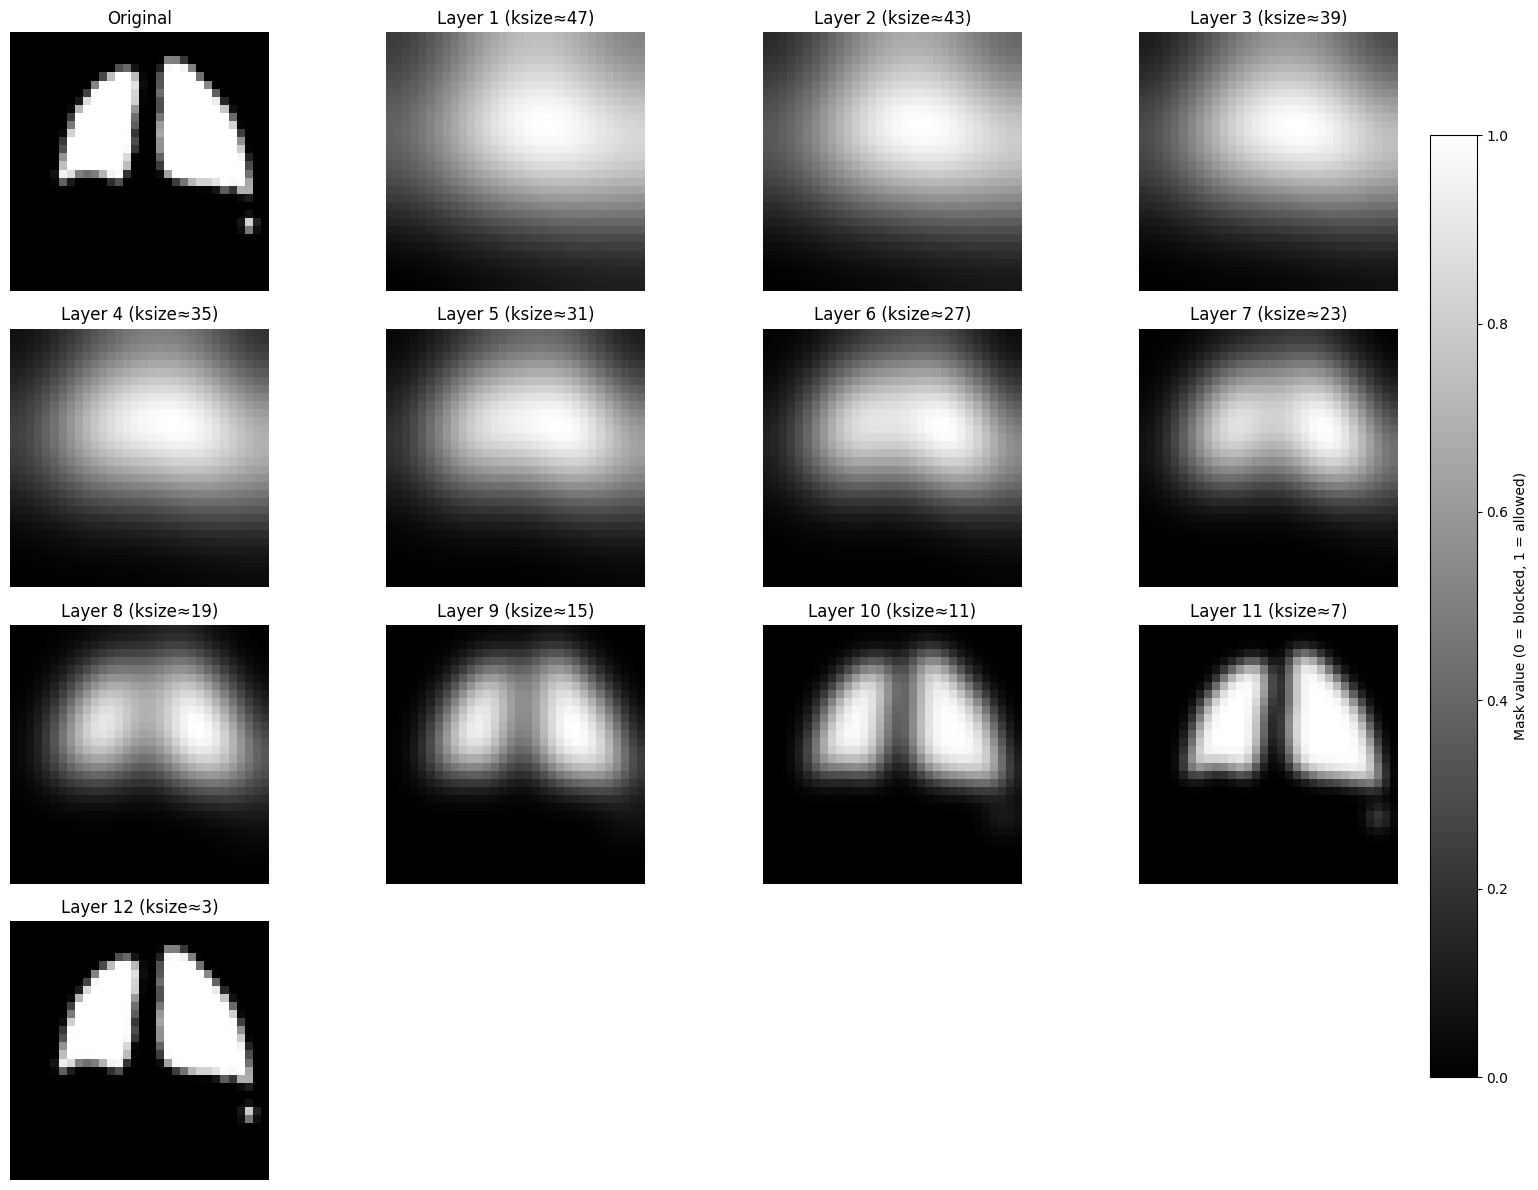

In [2]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from PIL import Image

# ------------------------------
# I/O config
# ------------------------------
images_path = "Datasets/MIMIC/matched_images_and_masks_mimic_224/images"
mask_path   = "Datasets/MIMIC/matched_images_and_masks_mimic_224/masks"
image_type  = ".jpg"

# ------------------------------
# Utils
# ------------------------------
def plot_one_image(image_id):
    full_path = f"{images_path}/{image_id}{image_type}"
    if os.path.exists(full_path):
        with Image.open(full_path) as im:
            im = im.convert("RGB")
            return im
    return None

def plot_one_mask(mask_id):
    full_path = f"{mask_path}/{mask_id}{image_type}"
    if os.path.exists(full_path):
        with Image.open(full_path) as im:
            # ensure single channel for a mask
            im = im.convert("L")  # grayscale 0..255
            return im
    return None

def normalize01(x, eps=1e-8):
    x = x.astype(np.float32, copy=False)
    xmin, xmax = x.min(), x.max()
    if xmax - xmin < eps:
        return np.zeros_like(x)
    return (x - xmin) / (xmax - xmin + eps)

# ------------------------------
# Gaussian kernel (finite, with kernel size)
# ------------------------------
def gaussian_kernel1d(ksize: int, sigma: float | None = None) -> np.ndarray:
    """
    Make a 1D Gaussian kernel of length ksize (odd).
    If sigma is None, choose sigma so that ~99% mass fits in the window:
        radius ≈ 3*sigma  =>  sigma ≈ (ksize-1)/6
    """
    k = int(ksize)
    if k < 1:
        k = 1
    if k % 2 == 0:
        k += 1  # enforce odd
    if sigma is None or sigma <= 0:
        sigma = (k - 1) / 6.0

    r = k // 2
    x = np.arange(-r, r + 1, dtype=np.float32)
    g = np.exp(-(x ** 2) / (2.0 * sigma * sigma))
    g /= g.sum()
    return g

def gaussian_blur2d_with_ksize(img: np.ndarray, ksize: int, sigma: float | None = None) -> np.ndarray:
    """
    Apply a separable 2D Gaussian blur using a kernel with explicit size.
    img: 2D float32 array
    """
    if img.ndim != 2:
        raise ValueError("gaussian_blur2d_with_ksize expects a 2D array")
    k1 = gaussian_kernel1d(ksize, sigma)              # (K,)
    # separable convolution: first along rows, then along cols
    tmp = ndi.convolve1d(img, k1, axis=1, mode="reflect")
    out = ndi.convolve1d(tmp, k1, axis=0, mode="reflect")
    return out

# ------------------------------
# Per-layer mask builder (now with kernel size)
# ------------------------------
def mask_per_layer(layer_idx: int,
                   base_mask: np.ndarray,
                   base_ksize: int = 5,
                   ksize_growth: int = 2,
                   sigma: float | None = None) -> np.ndarray:
    """
    Smooth the mask with a Gaussian of a given kernel size schedule.
    layer_idx is 0-based; kernel size grows with depth:
      ksize(layer) = base_ksize + layer_idx * ksize_growth (forced odd)
    Set ksize_growth=0 to keep the same kernel across layers.
    You can pass sigma explicitly or let it be derived from ksize.
    """
    ksize = base_ksize + layer_idx * ksize_growth
    # enforce odd
    if ksize % 2 == 0:
        ksize += 1
    smoothed = gaussian_blur2d_with_ksize(base_mask, ksize=ksize, sigma=sigma)
    return normalize01(smoothed)

# ------------------------------
# Load an example image/mask
# ------------------------------
# pick first entries
first_image_id = os.listdir(images_path)[0].split(".")[0]
first_mask_id  = os.listdir(mask_path)[0].split(".")[0]
print(f"First image ID: {first_image_id}")
print(f"First mask ID:  {first_mask_id}")

image = plot_one_image(first_image_id)
mask_img = plot_one_mask(first_mask_id)

if mask_img is None:
    raise FileNotFoundError("Could not load the first mask image.")

# Convert to float32 in [0,1]
mask_img = mask_img.resize((32, 32))  # resize to match GPT-2 input size (32x32 patches)
mask = np.array(mask_img, dtype=np.float32) / 255.0

# ------------------------------
# Build per-layer masks
# ------------------------------
num_layers = 12  # GPT-2 small
# Tweak these two knobs to control how big smoothing gets per layer:
BASE_KSIZE = 3      # starting kernel size (odd)
KSIZE_GROW = 4      # how much to increase per layer (will be forced odd)

masks = [normalize01(mask)] + [mask_per_layer(i, mask, BASE_KSIZE, KSIZE_GROW, sigma=None)
                               for i in range(num_layers-1,-1,-1)]
titles = ["Original"] + [f"Layer {i+1} (ksize≈{BASE_KSIZE + (11-i)*KSIZE_GROW})" for i in range(num_layers)]

# ------------------------------
# Plot
# ------------------------------
cols = 4
rows = math.ceil(len(masks) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
axes_flat = axes.flatten() if hasattr(axes, "flatten") else [axes]

im = None
for idx, ax in enumerate(axes_flat):
    if idx < len(masks):
        im = ax.imshow(masks[idx], cmap="gray", vmin=0.0, vmax=1.0, interpolation="nearest")
        ax.set_title(titles[idx])
        ax.axis("off")
    else:
        ax.axis("off")

fig.tight_layout()

if im is not None:
    cbar = fig.colorbar(im, ax=axes_flat, fraction=0.03, pad=0.02)
    cbar.set_label("Mask value (0 = blocked, 1 = allowed)")

plt.show()


batch_masks shape: (8, 32, 32, 12)
Saved: batch_layer_masks.npy


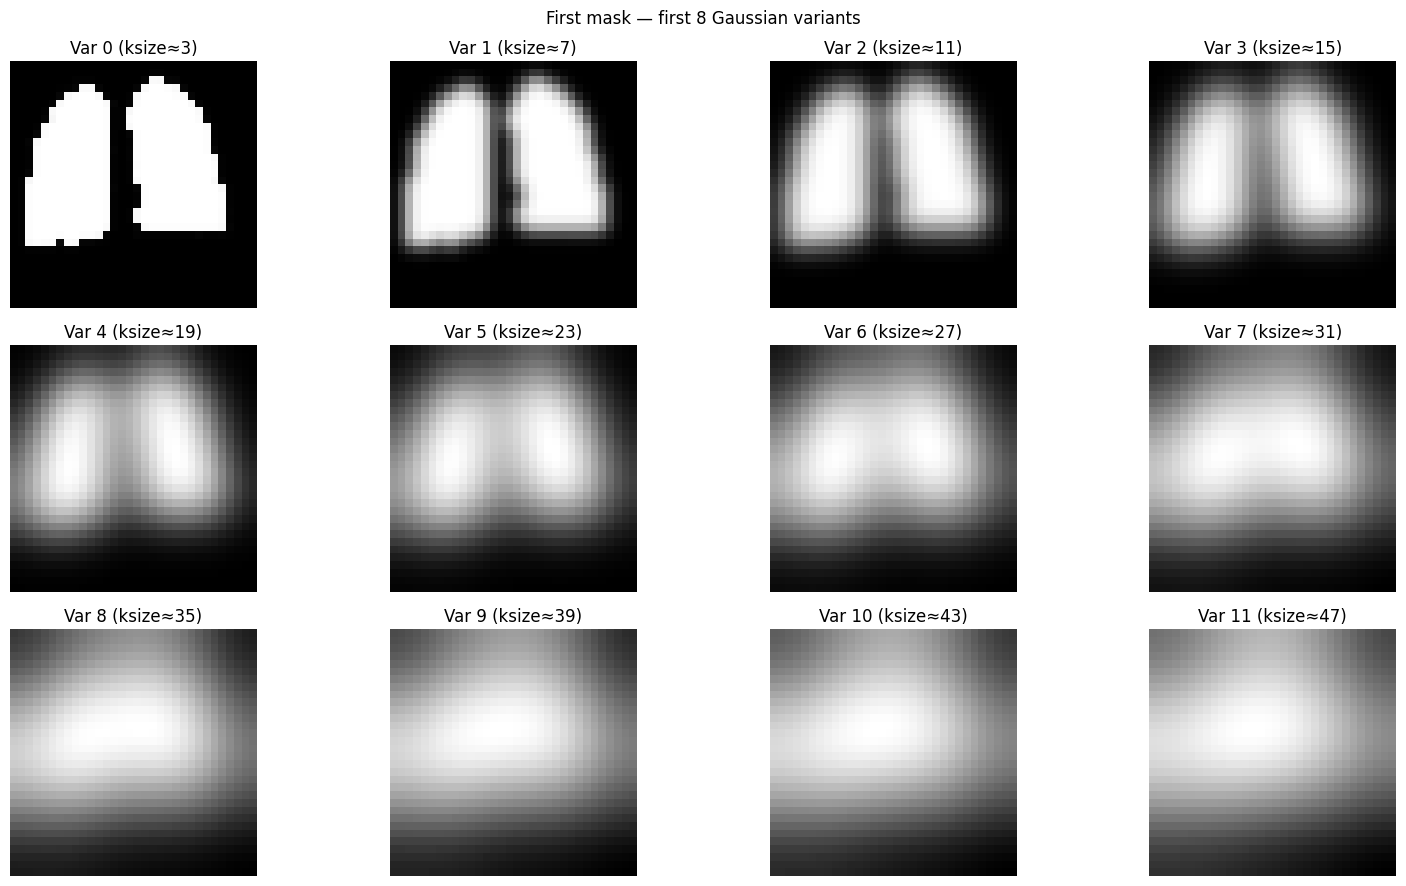

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from PIL import Image

# ------------------------------
# I/O config
# ------------------------------
images_path = "Datasets/MIMIC/matched_images_and_masks_mimic_224/images"
mask_path   = "Datasets/MIMIC/matched_images_and_masks_mimic_224/masks"
image_type  = ".jpg"

# ------------------------------
# Utils
# ------------------------------
def plot_one_image(image_id):
    full_path = f"{images_path}/{image_id}{image_type}"
    if os.path.exists(full_path):
        with Image.open(full_path) as im:
            return im.convert("RGB")
    return None

def plot_one_mask(mask_id):
    full_path = f"{mask_path}/{mask_id}{image_type}"
    if os.path.exists(full_path):
        with Image.open(full_path) as im:
            return im.convert("L")  # grayscale 0..255
    return None

def normalize01(x: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    x = x.astype(np.float32, copy=False)
    xmin, xmax = x.min(), x.max()
    if xmax - xmin < eps:
        return np.zeros_like(x)
    return (x - xmin) / (xmax - xmin + eps)

# ------------------------------
# Gaussian kernel (finite, with kernel size)
# ------------------------------
def gaussian_kernel1d(ksize: int, sigma: float | None = None) -> np.ndarray:
    """
    Make a 1D Gaussian kernel of length ksize (odd).
    If sigma is None, choose sigma so that ~99% mass fits in the window:
        radius ≈ 3*sigma  =>  sigma ≈ (ksize-1)/6
    """
    k = int(ksize)
    if k < 1:
        k = 1
    if k % 2 == 0:
        k += 1  # enforce odd
    if sigma is None or sigma <= 0:
        sigma = (k - 1) / 6.0

    r = k // 2
    x = np.arange(-r, r + 1, dtype=np.float32)
    g = np.exp(-(x ** 2) / (2.0 * sigma * sigma))
    g /= g.sum()
    return g

def gaussian_blur2d_with_ksize(img: np.ndarray, ksize: int, sigma: float | None = None) -> np.ndarray:
    """
    Apply a separable 2D Gaussian blur using a kernel with explicit size.
    img: 2D float32 array
    """
    if img.ndim != 2:
        raise ValueError("gaussian_blur2d_with_ksize expects a 2D array")
    k1 = gaussian_kernel1d(ksize, sigma)              # (K,)
    # separable convolution: first along rows, then along cols
    tmp = ndi.convolve1d(img, k1, axis=1, mode="reflect")
    out = ndi.convolve1d(tmp, k1, axis=0, mode="reflect")
    return out

# ------------------------------
# Build a bank of variants per mask (size = N_VARIANTS)
# ------------------------------
def build_mask_bank(base_mask: np.ndarray,
                    n_variants: int = 256,
                    base_ksize: int = 3,
                    ksize_growth: int = 2,
                    max_ksize: int | None = 63,
                    sigma: float | None = None) -> np.ndarray:
    """
    base_mask: (H,W) float32 in [0,1]
    Returns: (H,W,n_variants) float32 in [0,1]
    Kernel size schedule:
        k(i) = base_ksize + i*ksize_growth, forced odd, optionally clamped to max_ksize.
    """
    H, W = base_mask.shape
    bank = np.empty((H, W, n_variants), dtype=np.float32)

    for i in range(n_variants):
        k = base_ksize + i * ksize_growth
        if k % 2 == 0:
            k += 1
        if max_ksize is not None:
            # clamp to the nearest odd <= max_ksize
            k = min(k, max_ksize if max_ksize % 2 == 1 else max_ksize - 1)
            if k < 1:  # safety
                k = 1
        smoothed = gaussian_blur2d_with_ksize(base_mask, ksize=k, sigma=sigma)
        bank[:, :, i] = normalize01(smoothed)

    return bank

# ------------------------------
# Load a batch of 8 masks → resize to (32,32)
# ------------------------------
mask_files = sorted([f for f in os.listdir(mask_path) if f.lower().endswith(image_type)])
if len(mask_files) < 8:
    raise RuntimeError(f"Found only {len(mask_files)} mask files; need at least 8.")

mask_ids = [os.path.splitext(f)[0] for f in mask_files[:8]]

batch_list = []
for mid in mask_ids:
    mimg = plot_one_mask(mid)
    if mimg is None:
        raise FileNotFoundError(f"Mask {mid} not found at {mask_path}")
    # Resize to 32x32 for your attention grid (use NEAREST to preserve mask edges)
    mimg = mimg.resize((32, 32), resample=Image.NEAREST)
    m = np.array(mimg, dtype=np.float32) / 255.0  # [0,1], shape (32,32)
    batch_list.append(m)

batch_base = np.stack(batch_list, axis=0)  # (8,32,32)

# ------------------------------
# Build the 256-variant bank for each mask
# ------------------------------
N_VARIANTS = 12
BASE_KSIZE = 3   # starting kernel size (odd)
KSIZE_GROW  = 4  # increase per variant
MAX_KSIZE   = 63 # cap to keep kernels reasonable on 32x32; set None to disable

B, H, W = batch_base.shape
batch_masks = np.empty((B, H, W, N_VARIANTS), dtype=np.float32)

for b in range(B):
    bank = build_mask_bank(
        batch_base[b],
        n_variants=N_VARIANTS,
        base_ksize=BASE_KSIZE,
        ksize_growth=KSIZE_GROW,
        max_ksize=MAX_KSIZE,
        sigma=None,  # let sigma be derived from ksize
    )
    batch_masks[b] = bank

print("batch_masks shape:", batch_masks.shape)  # should be (8,32,32,N_VARIANTS)
assert batch_masks.shape == (8, 32, 32, N_VARIANTS)

# ------------------------------
# Save to disk
# ------------------------------
out_path = "batch_layer_masks.npy"
np.save(out_path, batch_masks)
print(f"Saved: {out_path}")

# ------------------------------
# Quick sanity plot (first mask, 8 variants)
# ------------------------------
show_n = 12
cols = 4
rows = math.ceil(show_n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
axes = axes.flatten() if hasattr(axes, "flatten") else [axes]

for i in range(show_n):
    axes[i].imshow(batch_masks[5, :, :, i], cmap="gray", vmin=0.0, vmax=1.0, interpolation="nearest")
    k_est = BASE_KSIZE + i * KSIZE_GROW
    if MAX_KSIZE is not None:
        k_est = min(k_est, MAX_KSIZE if MAX_KSIZE % 2 == 1 else MAX_KSIZE - 1)
    if k_est % 2 == 0: k_est += 1
    axes[i].set_title(f"Var {i} (ksize≈{k_est})")
    axes[i].axis("off")

for j in range(show_n, len(axes)):
    axes[j].axis("off")

fig.suptitle("First mask — first 8 Gaussian variants")
fig.tight_layout()
plt.show()


In [30]:
# pip install torch transformers
import torch
import torch.nn as nn
from transformers import GPT2TokenizerFast, GPT2LMHeadModel

# ---------- Utilidad: expandir máscara (32x32) -> (1024x1024) ----------
def expand_block_mask_to_token_mask(block_mask_32x32: torch.Tensor, block_size: int = 32) -> torch.Tensor:
    """
    block_mask_32x32: (B, 32, 32)   valores libres (p.ej. 0..1, negativos/positivos) que indican sesgo entre bloques
    Devuelve: (B, 1024, 1024) con repetición por Kronecker para mapear cada bloque a 32x32 tokens.
    """
    B, H32, W32 = block_mask_32x32.shape
    assert H32 == 32 and W32 == 32, "Se espera (32,32) por bloque."
    # kronecker product con una matriz de unos (32x32) para 'pixelar' cada celda de bloque a 32x32 tokens
    ones = torch.ones((block_size, block_size), device=block_mask_32x32.device, dtype=block_mask_32x32.dtype)
    token_mask = torch.kron(block_mask_32x32, ones)  # (B, 1024, 1024)
    return token_mask

# ---------- Construcción de sesgos por capa ----------
def build_layer_biases(masks_b323212: torch.Tensor, alpha: float = 1.0) -> list[torch.Tensor]:
    """
    masks_b323212: (B, 32, 32, 12)  -> 12 máscaras por capa
    alpha: factor de intensidad del sesgo (escala aditiva a los logits de atención)
    Return: lista de 12 tensores [(B, 1, 1024, 1024), ...]
    """
    assert masks_b323212.dim() == 4 and masks_b323212.size(1) == 32 and masks_b323212.size(2) == 32, \
        "Esperado (B, 32, 32, 12)."
    B, _, _, L = masks_b323212.shape
    assert L == 12, "Para GPT-2 (small) se esperan 12 capas."

    biases = []
    for l in range(L):
        block_mask = masks_b323212[..., l]                 # (B, 32, 32)
        token_bias = expand_block_mask_to_token_mask(block_mask)  # (B, 1024, 1024)
        # Añadir dimensión para heads: (B, 1, Q=1024, K=1024)
        token_bias = token_bias.unsqueeze(1)
        # Escalar por alpha (valor positivo = favorece; negativo = penaliza)
        token_bias = alpha * token_bias
        biases.append(token_bias)
    return biases

# ---------- Forward manual por capas para inyectar sesgo por capa ----------
class GPT2WithPerLayerBias(nn.Module):
    """
    Envueltura de GPT-2 que permite pasar una lista de `extra_attn_biases` (uno por capa),
    cada uno de forma (B, 1, 1024, 1024), que se suma a la máscara/score de atención
    además de la máscara causal estándar de GPT-2.
    """
    def __init__(self, base_model: GPT2LMHeadModel):
        super().__init__()
        self.model = base_model
        self.transformer = base_model.transformer
        self.lm_head = base_model.lm_head
        self.n_layer = self.transformer.config.n_layer
        self.n_positions = self.transformer.config.n_positions
        assert self.n_layer == 12, "Este ejemplo asume GPT-2 con 12 capas."

    @torch.no_grad()
    def generate_logits(
        self,
        input_ids: torch.Tensor,                      # (B, 1024)
        extra_attn_biases: list[torch.Tensor] | None  # list of 12 (B, 1, 1024, 1024)
    ) -> torch.Tensor:
        """
        Devuelve logits (B, 1024, vocab_size) con los sesgos aplicados.
        """
        device = input_ids.device
        B, T = input_ids.shape
        assert T == 1024, f"Se esperan 1024 tokens, recibido {T}."
        if extra_attn_biases is not None:
            assert len(extra_attn_biases) == self.n_layer
            for i, eb in enumerate(extra_attn_biases):
                assert eb.shape == (B, 1, T, T), f"Capa {i}: sesgo debe ser ({B},1,1024,1024), actualmente es {eb.shape}."

        # Embeddings
        pos_ids = torch.arange(0, T, dtype=torch.long, device=device).unsqueeze(0).expand(B, T)
        inputs_embeds = self.transformer.wte(input_ids) + self.transformer.wpe(pos_ids)
        hidden_states = self.transformer.drop(inputs_embeds)

        # No pasamos attention_mask de padding; GPT-2 ya aplica causalidad interna.
        # Vamos a agregar nuestro sesgo por-capa vía el argumento attention_mask con 4D,
        # que Transformers suma a los scores de atención (además del mask causal).
        # Muchos builds aceptan (B, 1, Q, K) como "aditive mask".
        # Si tu versión solo acepta (B, 1, 1, K), ver comentario al final.
        presents = () if self.transformer.config.use_cache else None
        all_hidden_states = ()
        for layer_idx, block in enumerate(self.transformer.h):
            if self.transformer.config.output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_bias = None
            if extra_attn_biases is not None:
                layer_bias = extra_attn_biases[layer_idx]  # (B, 1, T, T)

            outputs = block(
                hidden_states,
                layer_past=None,
                attention_mask=layer_bias,      # <- sesgo aditivo (además del causal interno)
                head_mask=None,
                encoder_hidden_states=None,
                encoder_attention_mask=None,
                use_cache=self.transformer.config.use_cache,
                output_attentions=False,
            )

            # Extract hidden_states robustly for tuple or ModelOutput
            if isinstance(outputs, tuple):
                hidden_states = outputs[0]
            else:
                hidden_states = getattr(outputs, 'last_hidden_state', None)
                if hidden_states is None:
                    try:
                        hidden_states = outputs[0]
                    except Exception:
                        raise RuntimeError("Unable to extract hidden_states from block outputs")

            if self.transformer.config.use_cache:
                # Extract present/past_key_values robustly across HF versions
                present = None
                if isinstance(outputs, tuple):
                    if len(outputs) > 1:
                        present = outputs[1]
                else:
                    present = getattr(outputs, 'past_key_values', None)
                    if present is None:
                        present = getattr(outputs, 'present_key_values', None)
                    if present is None:
                        present = getattr(outputs, 'present', None)
                presents = presents + (present,)

        hidden_states = self.transformer.ln_f(hidden_states)
        logits = self.lm_head(hidden_states)  # (B, T, vocab)
        return logits

# ----------------- Ejemplo de uso -----------------

device = "cuda" if torch.cuda.is_available() else "cpu"

# Modelo/tokenizer (GPT-2 small; n_layer=12, n_positions=1024 por defecto moderno)
tok = GPT2TokenizerFast.from_pretrained("gpt2")
# Asegura que el modelo tenga n_positions>=1024 (gpt2 normal es 1024). Si tu checkpoint lo tuviera menor, ajusta config.
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.to(device).eval()

wrapper = GPT2WithPerLayerBias(model)

# Dummy entrada de exactamente 1024 tokens (rellena o usa tus ids reales)
text = "Hello world. " * 200  # ~2400 caracteres; luego truncamos a 1024 tokens
ids = tok(text, return_tensors="pt", add_special_tokens=False, truncation=True, max_length=1024)["input_ids"].to(device)
# Si faltan tokens, puedes padear a 1024 con un token permitido (p.ej. tok.eos_token_id)
if ids.size(1) < 1024:
    pad = torch.full((ids.size(0), 1024 - ids.size(1)), tok.eos_token_id, device=device, dtype=ids.dtype)
    ids = torch.cat([ids, pad], dim=1)

B = ids.size(0)

# Tus máscaras por bloques: (B, 32, 32, 12)
# Ejemplo: favorecer diagonal (q≈k) y una banda de contexto temprano (k en primeras columnas)
# masks = torch.zeros((B, 32, 32, 12), device=device)
masks = batch_masks[0] # (32, 32, 12)
masks = torch.tensor(masks, device=device).expand(B, -1, -1, -1)  # (B, 32, 32, 12)
for l in range(12):
    base = torch.zeros((B, 32, 32), device=device)
    # favorece diagonal de bloques
    base[:, torch.arange(32), torch.arange(32)] = 1.0
    # favorece primeras 4 columnas de bloques (primeros 128 tokens como claves)
    base[:, :, :4] += 0.5
    masks[..., l] = base

# Construir sesgos por capa (escala alpha controla "qué tanto" empuja la atención)
extra_biases = build_layer_biases(masks, alpha=0.75)  # prueba 0.2–2.0 según tu necesidad

# Logits con sesgo aplicado (causalidad se mantiene)
with torch.no_grad():
    logits = wrapper.generate_logits(ids, extra_biases)  # (B, 1024, vocab)
    # Ejemplo: prob. del último token
    probs_last = torch.softmax(logits[:, -1, :], dim=-1)

print("OK, logits con sesgo por capa:", logits.shape, "probs_last:", probs_last.shape)


OK, logits con sesgo por capa: torch.Size([1, 1024, 50257]) probs_last: torch.Size([1, 50257])
